This code is run and tested on the Python 3.7.4 interpreter. Owlready2 was installed with `pip install owlready2`. It is the latest version owlready2 at this time - 0.40

Note that aliasing owlready2 as owl is not a common practice (like aliasing numpy with np, or pandas with pd) - I just like it.

In [1]:
import owlready2 as owl 
owl.VERSION

* Owlready2 * Warning: optimized Cython parser module 'owlready2_optimized' is not available, defaulting to slower Python implementation


'0.40'

If we wanted to access an ontology we need to load it.

In [2]:
ontology = owl.get_ontology('../../ontology/io_prototype.rdf').load()

Access to the lists of entries within the ontology is implemented with the generators

In [3]:
print(ontology.classes())
print(ontology.annotation_properties())
print(ontology.data_properties())
print(ontology.object_properties())
print(ontology.individuals())

<generator object _GraphManager.classes at 0x000001FE59228A50>
<generator object _GraphManager.annotation_properties at 0x000001FE59228A50>
<generator object _GraphManager.data_properties at 0x000001FE59228A50>
<generator object _GraphManager.object_properties at 0x000001FE59228A50>
<generator object _GraphManager.individuals at 0x000001FE59228A50>


In [4]:
for individual in ontology.individuals():
    print(individual)

io_prototype.mass
io_prototype.volume
io_prototype.boiled_carrots
io_prototype.carrot_raw_diced
io_prototype.drinking_water
io_prototype.x_idi1
io_prototype.x_idi2
io_prototype.x_ings1
io_prototype.x_ingsp1
io_prototype.x_ingsp2


* Owlready2 * Warning: ignoring cyclic type of, involving storid 2309

* Owlready2 * Warning: ignoring cyclic type of, involving storid 2372



Note that most of the classes in the current prototype are imported from OBO, FoodON, UO, PATO and general ontologies, such as IAO or RO.

In [5]:
iter = 5
for cls in ontology.classes():
    print(cls, end=', ')
    iter -= 1
    if iter == 1:
        break

obo.BFO_0000002, obo.BFO_0000003, obo.BFO_0000004, obo.BFO_0000017, 

If we know the name of the class we want to process (it's actual name within the namespace of the ontology, not the label), we can get it like this:

In [6]:
ontology.food_reciepe

io_prototype.food_reciepe

However, generally we will be dealing with imported classes. Loading a class, knowing it's IRI is also quite simple.

In [7]:
owl.IRIS['http://purl.obolibrary.org/obo/BFO_0000002']

obo.BFO_0000002

In the current version I'm using my own definitions for the following classes:

 - food reciepe
 - device set
 - ingredient set
 - instruction set
 - ingredient specification
and properties
 - is about
 - has member
 - has quantity


However, all of them have equivalents in the source ontologies

 - Ingredient set: http://purl.obolibrary.org/obo/FOODON_00004082
 - Instruction set: http://purl.obolibrary.org/obo/FOODON_00004084
 - Device set: http://purl.obolibrary.org/obo/FOODON_00004084
 - Food reciepe: http://purl.obolibrary.org/obo/FOODON_00004081
 - Ingredient specification: http://purl.obolibrary.org/obo/FOODON_00004085

object properties
- 'is about' : http://purl.obolibrary.org/obo/IAO_0000136
- 'has member' : http://purl.obolibrary.org/obo/RO_0002351

data properties:
'has quantity' : http://purl.obolibrary.org/obo/COB_0000511

we will very likely end up using the existing properties.

Currently in the ontology, there is one food reciepe: Boiled Carrots

In [8]:
food_reciepe_class : owl.ClassConstruct = ontology.food_reciepe
for instance in ontology.get_instances_of(food_reciepe_class):
    print(instance)

io_prototype.boiled_carrots


Currently we are using a one-directional component_of relation. So we cannot get the ingredient set directly from this individual. Instead we need to search trough all ingredient sets and check wether it is connected to this reciepe via 'component_of' relation

In [9]:
food_reciepe_class : owl.ClassConstruct = ontology.food_reciepe
component_class : owl.ClassConstruct = ontology.ingredient_set
for instance in ontology.get_instances_of(food_reciepe_class):
    print(instance)
    for component_set in ontology.get_instances_of(component_class):
        if instance in component_set.component_of:
            print(component_set)
        

io_prototype.boiled_carrots
io_prototype.x_ings1


Specific components of the component set are connected to the set via 'has_component' relation.

In [10]:
food_reciepe_class : owl.ClassConstruct = ontology.food_reciepe
component_class : owl.ClassConstruct = ontology.ingredient_set
for instance in ontology.get_instances_of(food_reciepe_class):
    print(instance)
    for component_set in ontology.get_instances_of(component_class):
        if instance in component_set.component_of:
            print(f'\t{component_set}')
            for component in component_set.has_component:
                    print(f'\t\t{component}')

io_prototype.boiled_carrots
	io_prototype.x_ings1
		io_prototype.x_ingsp1
		io_prototype.x_ingsp2


Components are connected with their specification via 'has_component' relation. Components are about food materials. The relation between food material and components is 'is_about'.

In [11]:
food_reciepe_class : owl.ClassConstruct = ontology.food_reciepe
component_class : owl.ClassConstruct = ontology.ingredient_set
for instance in ontology.get_instances_of(food_reciepe_class):
    print(instance)
    for component_set in ontology.get_instances_of(component_class):
        if instance in component_set.component_of:
            print(f'\t{component_set}')
            for component in component_set.has_component:
                    print(f'\t\t{component}')
                    for food in component.is_about:
                        print(f'\t\t\tIs About: {food}')
                    for specification in component.has_component:
                        print(f'\t\t\t{specification}')
                        print(f'\t\t\t\t{specification.has_unit[0].label[0]}')
                        print(f'\t\t\t\t{specification.has_quantity[0]}')
                        print(f'\t\t\t\t{specification.is_quality_measure_of[0]}')

io_prototype.boiled_carrots
	io_prototype.x_ings1
		io_prototype.x_ingsp1
			Is About: io_prototype.drinking_water
			io_prototype.x_idi1
				teaspoon
				0.5
				io_prototype.volume
		io_prototype.x_ingsp2
			Is About: io_prototype.carrot_raw_diced


In order to create a new instance, well, we simply create it. First we need to recognize the class, of the instance we want to create, and then simply create it.

In [12]:
new_reciepe1 = ontology.food_reciepe()
new_reciepe2 = food_reciepe_class()

#new_reciepe3 = owl.IRIS[class iri]
print(new_reciepe1)
print(new_reciepe2)

io_prototype.food_reciepe1
io_prototype.food_reciepe2


For custom IRIs we create it like this

In [13]:
new_reciepe3 = ontology.food_reciepe('TAISTI_0000123')
new_reciepe3
new_reciepe3.iri

'http://www.semanticweb.org/student/ontologies/2023/2/io_prototype.owl#TAISTI_0000123'

The goal is to map the JSON files into fragments of a graph, created upon the class definitions from the source ontologies.

In [14]:
import json
sample = json.load(open('../../samples/sample_afterlexmappr_beforekg.json'))
sample

{'name': 'Cheesburger Potato Soup',
 'oboId': '',
 'match': 'No Match',
 'ingredientSet': [{'name': 'potato',
   'oboId': 'FOODON_03302197',
   'match': 'Full Match',
   'quantity': '6',
   'unit': ''},
  {'name': 'extra lean ground beef',
   'oboId': 'FOODON_00001282',
   'match': 'Component Match',
   'quantity': '1',
   'unit': 'lb'},
  {'name': 'butter',
   'oboId': 'FOODON_03310351',
   'match': 'Full Term Match',
   'quantity': '2/3',
   'unit': 'c'}],
 'deviceSet': [{'name': 'microwave',
   'oboId': 'OBI:0001061',
   'match': 'Full Match'},
  {'name': 'kettle', 'oboId': '', 'match': 'No Match'}],
 'instructionSet': [{'stepNo': '1',
   'content': 'Wash potatoes; prick several times with a fork.',
   'process': '',
   'oboId': '',
   'match': 'No Match'},
  {'stepNo': '2',
   'content': 'Microwave them with a wet paper towel covering the potatoes on high for 6-8 minutes.',
   'process': 'cooking by microwave',
   'oboId': 'FOODON:03450011',
   'match': 'Component Match'}]}

Let's start by loading the foodon ontology. (the github source is temporary, we need to find a proper online source for the ontology)

In [15]:
foodon_ontology = owl.get_ontology('https://raw.githubusercontent.com/FoodOntology/foodon/master/foodon.owl').load()

We can parse the ingredient set and convert the classes within the set to what we need. Remember, that the obiId is not the full IRI, we still need to use the prefix.

In [16]:
for ingredient in sample['ingredientSet']:
    food = owl.IRIS['http://purl.obolibrary.org/obo/' + ingredient['oboId']]
    print(food.label)
    #I'm also printing out the list of ancestors, to see whether the classes have a common ancestor (food material in this case)
    #we need to do something like this to make sure, we are not trying to make a 'soup' reciepe with 'processes' as ingredients
    for ancestor in food.ancestors():
        print(f'\t{ancestor.label}')

['potato (boiled)']
	['solanaceous root food product']
	['material entity', 'material entity', 'material entity', 'material entity']
	['plant root food product']
	['independent continuant', 'independent continuant', 'independent continuant', 'independent continuant']
	['food product by organism']
	['plant food product']
	['potato (boiled)']
	[]
	['food product']
	['continuant', 'continuant', 'continuant', 'continuant']
	['potato food product']
	['food material', 'food material']
	['entity', 'entity', 'entity', 'entity']
	['solanaceous food product']
['ground beef food product']
	['vertebrate animal food product']
	['material entity', 'material entity', 'material entity', 'material entity']
	['food material', 'food material']
	['entity', 'entity', 'entity', 'entity']
	['independent continuant', 'independent continuant', 'independent continuant', 'independent continuant']
	['food product by organism']
	['animal food product']
	[]
	['food product']
	['continuant', 'continuant', 'continuan

Now we need to think what to do. Is each of the ingredients a new individual? Or perhaps we are class pruning, and we are just referring to a food class trough an individual. Let's use the simple approach first and simply create an individual for each ingredient (notice the IDs of newly created objects).

In [17]:
for ingredient in sample['ingredientSet']:
    food = owl.IRIS['http://purl.obolibrary.org/obo/' + ingredient['oboId']]
    ingredient_food = food()
    print(foodon_ontology.get_instances_of(food))

[obo.foodon_033021971]
[obo.foodon_000012821]
[obo.foodon_033103511]


The idea is to create a graph for each of the reciepes using this method.
Owlready2 operates on worlds. Each world can consist of multiple ontologies. Let's look for all the graph elements we need in order to create a single entry outline. 

We can use the search function, which traverses over all ontologies and looks for entries, which are related to a given query. We can specify the label of an entry we are looking for. Let's use an example mapping to see what do we need.

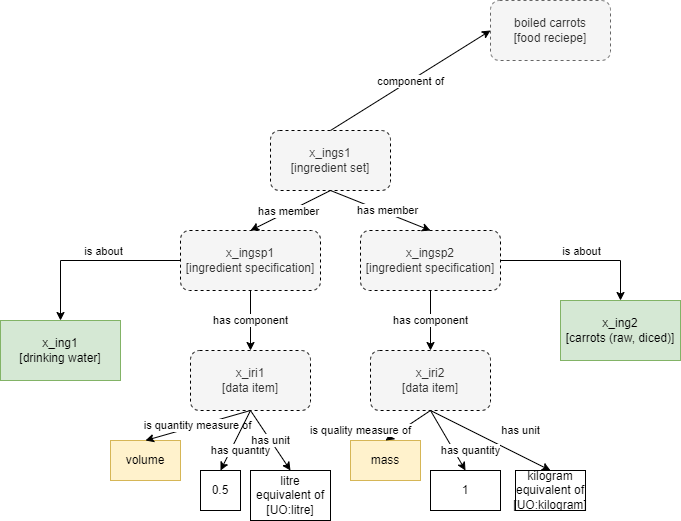

In [78]:
from IPython.display import Image
display(Image(filename='../../docs/images/BindingWithUnitsOntology.png'))

First we are going to populate our world. This should happen only once, altough subsequent calls of the get ontology function with an ontology that is already in the world are handled by the library (resources are not loaded if they are already loaded).

In [1]:
import owlready2 as owl


owl.default_world.get_ontology("https://raw.githubusercontent.com/FoodOntology/foodon/master/foodon.owl").load()
owl.default_world.get_ontology("https://raw.githubusercontent.com/pato-ontology/pato/master/pato.owl").load()
owl.default_world.get_ontology("https://raw.githubusercontent.com/bio-ontology-research-group/unit-ontology/master/uo.owl").load()
owl.default_world.get_ontology("https://raw.githubusercontent.com/information-artifact-ontology/IAO/v2022-11-07/iao.owl").load()




* Owlready2 * Warning: optimized Cython parser module 'owlready2_optimized' is not available, defaulting to slower Python implementation


get_ontology("http://purl.obolibrary.org/obo/iao.owl#")

Then find the properties we need

In [9]:
food_recipe = owl.default_world.search(label="food recipe")[0]
ingredient_set = owl.default_world.search(label="ingredient set")[0]
ingredient_specification = owl.default_world.search(label="ingredient specification")[0]
data_item = owl.default_world.search(label="data item")[0]
is_about_prop = owl.default_world.search(label="is about")[0]
has_quantit_prop = owl.default_world.search(label="has quantity")[0]
has_member_prop = owl.default_world.search(label="has component")[0]


In [10]:
print(food_recipe)
print(ingredient_set)
print(ingredient_specification)
print(data_item)
print(is_about_prop)
print(has_quantit_prop)
print(has_member_prop)

obo.FOODON_00004081
obo.FOODON_00004082
obo.FOODON_00004085
obo.IAO_0000027
obo.IAO_0000136
obo.COB_0000511
obo.RO_0002180


In [8]:
print(owl.default_world["http://purl.obolibrary.org/obo/FOODON_00004082"].label)

['ingredient set']
